# Predict survival of the passengers of Titanic

<img src="./titanic2.png" width="1024" height="200" alt="Caption for the image">

## Import

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(context = 'paper', palette = 'winter_r', style = 'darkgrid', rc= {'figure.facecolor': 'gray',}, font_scale=1.5)


In [4]:
d_train=pd.read_csv("titanic_train.csv")
d_test=pd.read_csv("titanic_test.csv")
d_pred=pd.read_csv("titanic_test_results.csv") #titanic_predictions_svm_with_groups

## See

In [6]:
d_train.columns, d_test.columns, d_pred.columns

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'),
 Index(['PassengerId', 'Survived'], dtype='object'))



- Survived: Wheather the person Survived or not.

- Pclass: Passanger class indicates the class of that person aboard the ship.

- SibSp: Shows the number of Sibling/Spouces they had.

- Parch: Parch indicates Parents with children

- TIcket: Ticket name/Number.

- Fare: How much the Passenger paid.

- Cabin: Cabin name of that Passenger.

- Embarked: Point of Embarkation where C means Cherbourg, Q means Queenstown, S means Southampton.


In [8]:
d_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
d_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


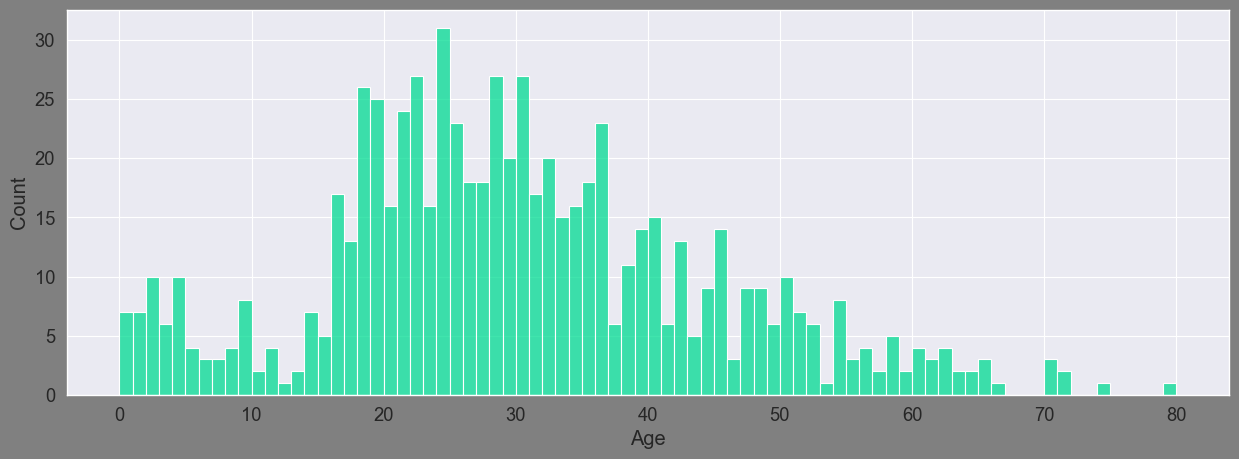

In [10]:
# A idade mínima é 0.42 e a máxima é 80. Como se distribuem as idades dos passageiros?

plt.figure(figsize = [15,5])
sns.histplot(d_train['Age'].dropna(),bins = range(0,81,1))
plt.show()

In [11]:
# 25% dos bilhetes custaram menos de 8. No entanto, há bilhete(s) de 512. O que sabemos sobre esse(s) passageiro(s)?

d_train[d_train["Fare"]>500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


### OBS
- Nem todos têm idade
- nr de únicos (nunique() vs unique() )

In [13]:
d_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [14]:
d_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [15]:
# Quantos passageiros embarcaram em cada um dos 3 portos?
d_train.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [16]:
# Quantos sobreviventes por porto de embarque?

#d_train.groupby('Embarked').sum()['Survived']
d_train[d_train['Survived']==1].Embarked.value_counts()

Embarked
S    217
C     93
Q     30
Name: count, dtype: int64

In [17]:
# Quantas vezes aparece o mesmo número de bilhete?
d_train.Ticket.value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [18]:
# O bilhete 347082 aparece 7 vezes. Quais os passageiros?

d_train[d_train.Ticket == '347082']
# provavelmente passageiros com bilhete de grupo mesma Pclass e mesmo Embarked

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


In [19]:
# Qual a média de idades das senhoras e dos homens?
print(f'Média senhoras:{d_train[d_train.Sex=="female"].Age.mean():.1f}')
print(f'Média homens:  {d_train[d_train.Sex=="male"].Age.mean():.1f}')

Média senhoras:27.9
Média homens:  30.7


In [20]:
#verificar se tem NaN
d_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [21]:
#Faltam muitos dados na Cabin
d_train.Cabin.isnull().value_counts()

Cabin
True     687
False    204
Name: count, dtype: int64

In [22]:
# vamos criar uma matriz (um dataframe) com a contagem de nulos, de cada atributo, em cada um dos dataframes (treino e teste)
nulos=pd.DataFrame(d_train.isnull().sum(),columns=["Treino"])
nulos["Teste"]=d_test.isnull().sum()
nulos

,Treino,Teste
PassengerId,0,0.0
Survived,0,NaN
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,177,86.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,1.0


In [23]:
d_train.Cabin.value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [24]:
# vamos procurar correlações
d_train.corr(numeric_only = True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


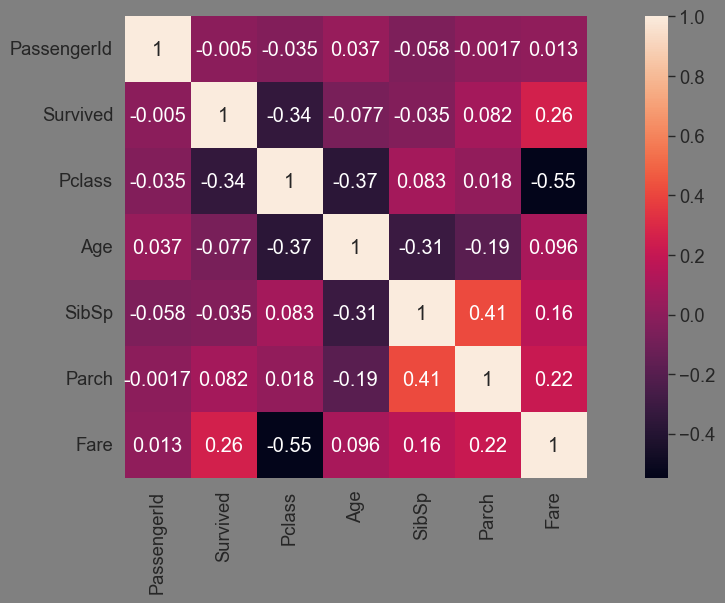

In [25]:
# heatmap com os dados da matriz de correlação
f, ax = plt.subplots(figsize = [15,6])
sns.heatmap(d_train.corr(numeric_only = True), square = True,annot = True)
plt.show()

## Pre-process

- Name não traz informação, podemos eliminar
- juntar dados para pre-processar
    - até agora os dados eram separados em treino e teste após o pré-proc
    - neste caso, são dados que já estão separados
- o dataset é pequeno e precisamos de aumentar a possibilidade de capturar todas as alternativas
- evitar dados fora dos limites, novas classes, etc se pre-processar apenas Treino
- Em problemas reais, quando já temos o sistema em produção e chegam novos dados, estes tb têm que passar pela pipeline de pré-proc

In [28]:
df=pd.concat([d_train,d_test])
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [29]:
# a colna index não está com valores de 0 a 1308, mas sim de 0 a 891 e 0 a 417. É importante refazer este indice
df=pd.concat([d_train,d_test]).reset_index(drop=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [30]:
# podemos usar o passengerId como indice
#df=pd.concat([d_train,d_test]).set_index("PassengerId")
#df

In [31]:
#df=df.drop("Name",axis=1)
#df

In [32]:
df.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

In [33]:
df.SibSp.value_counts()

SibSp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64

In [34]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### dados incompletos
- survived: são os de teste
- age, fare, cabin, embarked, Name

### estratégias
- age
- fare - vamos ver o valor médio de cada classe e atribuir a esta linha o valor da sua classe
- cabin - faltam muitos valores e há uma grande diversidade nos existentes. Por um lado, a coluna não contem informação útil e por outro, o seu preenchimento nao pode ser feito sem introduzir muito erro. Solução: drop da coluna
- name - idem
- embarked - como os dados são muito desbalanceados para a classe "S" (ver abaixo), poderíamos preencher com esse valor. No entanto, como só faltam 2 valores, numa estratégia pedagogica, vamos fazer o drop das linhas. 

In [36]:
df["Embarked"].value_counts()
# S+C+Q=1307
# e faltam 2
# total=1309 

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [37]:
df=df.drop(["Name","Cabin","PassengerId"],axis=1)

In [38]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1.0,1,female,35.0,1,0,113803,53.1000,S
4,0.0,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,NaN,0,0,A.5. 3236,8.0500,S
1305,NaN,1,female,39.0,0,0,PC 17758,108.9000,C
1306,NaN,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,NaN,3,male,NaN,0,0,359309,8.0500,S


In [39]:
# esta função (dropna) elimina as linhas com nulos na(s) coluna(s) indicada(s). Em todas se não for indicada nenhuma
df=df.dropna(subset=["Embarked"])
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1.0,1,female,35.0,1,0,113803,53.1000,S
4,0.0,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,NaN,0,0,A.5. 3236,8.0500,S
1305,NaN,1,female,39.0,0,0,PC 17758,108.9000,C
1306,NaN,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,NaN,3,male,NaN,0,0,359309,8.0500,S


In [40]:
# qual a média dos atributos numéricos de cada classe?
df.drop(['Survived','Sex','Ticket','Embarked'],axis=1).groupby("Pclass").mean()

,Age,SibSp,Parch,Fare
Pclass,,,,
1,39.083050,0.439252,0.367601,87.555777
2,29.506705,0.393502,0.368231,21.179196
3,24.816367,0.568406,0.400564,13.302889


In [41]:
def tarifa(df,classe):
    return df.drop(['Survived','Sex','Ticket','Embarked'],axis=1).groupby("Pclass").mean().Fare[classe]

tarifa(df,3)

13.302888700564973

In [42]:
# Qual é a linha sem Fare 

df[df.Fare.isnull()]

# é a linha 1043
# o passageiro viajava em 3 classe
# o valor médio do bilhete de 3ª classe é tarifa(df,3), ou seja 13.302

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1043,NaN,3,male,60.5,0,0,3701,NaN,S


In [43]:
#df.loc[df['Fare'].isnull(),'Fare']=13.3
df.loc[1043,'Fare']=13.3

In [44]:
df[df.Fare.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


In [45]:
# passageiros sem Age
df['Age'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
1304     True
1305    False
1306    False
1307     True
1308     True
Name: Age, Length: 1307, dtype: bool

In [46]:
### AGE
#calcular a média por género
df.drop(['Survived','Ticket','Embarked'],axis=1).groupby("Sex").mean().Age

Sex
female    28.576658
male      30.585228
Name: Age, dtype: float64

In [47]:
df[df.Age.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
5,0.0,3,male,NaN,0,0,330877,8.4583,Q
17,1.0,2,male,NaN,0,0,244373,13.0000,S
19,1.0,3,female,NaN,0,0,2649,7.2250,C
26,0.0,3,male,NaN,0,0,2631,7.2250,C
28,1.0,3,female,NaN,0,0,330959,7.8792,Q
...,...,...,...,...,...,...,...,...,...
1299,NaN,3,female,NaN,0,0,334915,7.7208,Q
1301,NaN,3,female,NaN,0,0,365237,7.7500,Q
1304,NaN,3,male,NaN,0,0,A.5. 3236,8.0500,S
1307,NaN,3,male,NaN,0,0,359309,8.0500,S


In [48]:

df['Age']=df['Age'].fillna((df['Age'].mean()))

C:\Users\garfi\AppData\Local\Temp\ipykernel_2128\2958054739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age']=df['Age'].fillna((df['Age'].mean()))


In [49]:
df.isnull().sum()

Survived    418
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
dtype: int64

In [50]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,0.382452,2.296863,29.842596,0.499617,0.385616,33.208712
std,0.486260,0.836942,12.860376,1.042273,0.866092,51.749098
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,29.842596,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [51]:
# Mulheres e crianças
analise=df.groupby("Sex").count()
analise['percentagem']=analise.Survived/analise.Embarked*100
#drop
analise

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,percentagem
Sex,,,,,,,,,
female,312,464,464,464,464,464,464,464,67.241379
male,577,843,843,843,843,843,843,843,68.446026


In [52]:
#s=df[df['Survived']==1]
s=df.loc[df['Survived']==1,["Age",'Sex']]
s

,Age,Sex
1,38.0,female
2,26.0,female
3,35.0,female
8,27.0,female
9,14.0,female
...,...,...
875,15.0,female
879,56.0,female
880,25.0,female
887,19.0,female


<Figure size 1700x600 with 0 Axes>

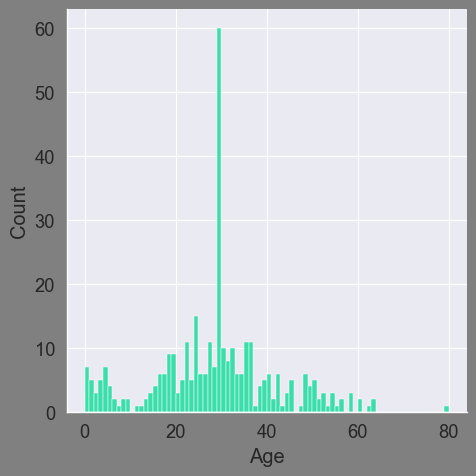

In [53]:
plt.figure(figsize = [17,6])
a = sns.displot(s['Age'].dropna(),bins = range(0,81,1))
plt.show()

<Figure size 1700x600 with 0 Axes>

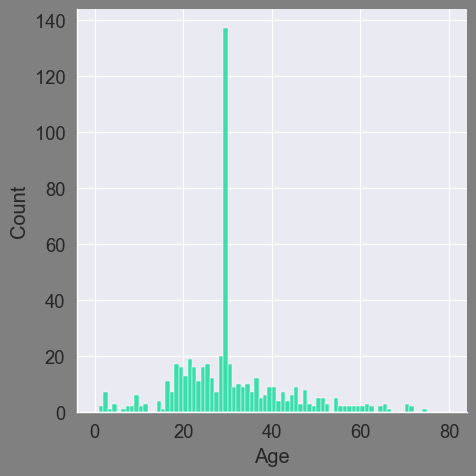

In [54]:
#s=df[df['Survived']==1]
ns=df.loc[df['Survived']==0,["Age",'Sex']]
#s
plt.figure(figsize = [17,6])
a = sns.displot(ns['Age'].dropna(),bins = range(0,81,1))
plt.show()

In [55]:
survived=df[df.Survived == 1]
didnt=df[df.Survived == 0]

In [56]:
survived.Age, didnt.Age

(1      38.0
 2      26.0
 3      35.0
 8      27.0
 9      14.0
        ... 
 875    15.0
 879    56.0
 880    25.0
 887    19.0
 889    26.0
 Name: Age, Length: 340, dtype: float64,
 0      22.000000
 4      35.000000
 5      29.842596
 6      54.000000
 7       2.000000
          ...    
 884    25.000000
 885    39.000000
 886    27.000000
 888    29.842596
 890    32.000000
 Name: Age, Length: 549, dtype: float64)

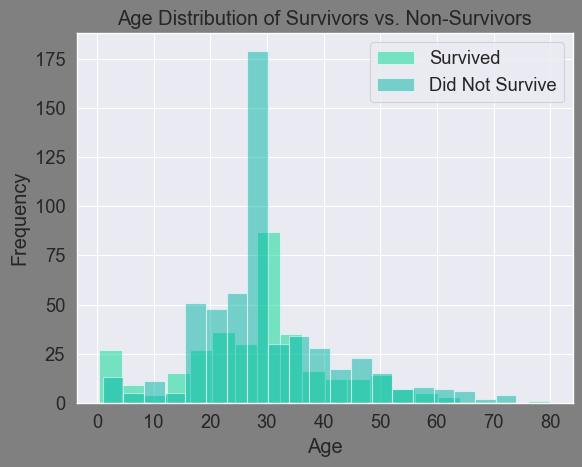

In [57]:
plt.hist(survived.Age, alpha=0.5, label='Survived', bins=20)
plt.hist(didnt.Age, alpha=0.5, label='Did Not Survive', bins=20)
plt.legend(loc='upper right')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Survivors vs. Non-Survivors')
plt.show()


### encoding

In [59]:
df.dtypes

Survived    float64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Embarked     object
dtype: object

___ As features do tipo Object têm que ser convertidas para tipos numéricos ___

In [61]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

__ #OneHot usado na célula seguinte  
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

c=['Sex', 'Ticket', 'Embarked']
__ # encoding feito nas colunas c, mantendo toda a dataframe df - as outras colunas não são alteradas mas mantêm-se
df[c]=enc.fit_transform(df[c])
enc.categories_

In [63]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

In [64]:
c=['Sex', 'Ticket', 'Embarked']
# encoding feito nas colunas c, mantendo toda a dataframe df - as outras colunas não são alteradas mas mantêm-se
encoded_data = encoder.fit_transform(df[c])
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['110152', '110413', '110465', '110469', '110489', '110564',
        '110813', '111163', '111240', '111320', '111361', '111369',
        '111426', '111427', '111428', '112050', '112051', '112052',
        '112053', '112058', '112059', '112277', '112377', '112378',
        '112379', '112901', '113028', '113038', '113043', '113044',
        '113050', '113051', '113054', '113055', '113056', '113059',
        '113501', '113503', '113505', '113509', '113510', '113514',
        '113760', '113767', '113773', '113776', '113778', '113780',
        '113781', '113783', '113784', '113786', '113787', '113788',
        '113789', '113790', '113791', '113792', '113794', '113795',
        '113796', '113798', '113800', '113801', '113803', '113804',
        '113806', '113807', '11668', '11751', '11752', '11753', '11755',
        '11765', '11767', '11769', '11770', '11771', '11774', '11778',
        '11813', '11967', '1222', '12233', '12460', '12749', '1304

In [65]:
encoded_data

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [66]:
feature_names = encoder.get_feature_names_out(['Sex', 'Ticket', 'Embarked'])

In [67]:
df0=df
df0

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0.0,3,male,22.000000,1,0,A/5 21171,7.2500,S
1,1.0,1,female,38.000000,1,0,PC 17599,71.2833,C
2,1.0,3,female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,1.0,1,female,35.000000,1,0,113803,53.1000,S
4,0.0,3,male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,29.842596,0,0,A.5. 3236,8.0500,S
1305,NaN,1,female,39.000000,0,0,PC 17758,108.9000,C
1306,NaN,3,male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,NaN,3,male,29.842596,0,0,359309,8.0500,S


In [68]:
feature_names

array(['Sex_female', 'Sex_male', 'Ticket_110152', 'Ticket_110413',
       'Ticket_110465', 'Ticket_110469', 'Ticket_110489', 'Ticket_110564',
       'Ticket_110813', 'Ticket_111163', 'Ticket_111240', 'Ticket_111320',
       'Ticket_111361', 'Ticket_111369', 'Ticket_111426', 'Ticket_111427',
       'Ticket_111428', 'Ticket_112050', 'Ticket_112051', 'Ticket_112052',
       'Ticket_112053', 'Ticket_112058', 'Ticket_112059', 'Ticket_112277',
       'Ticket_112377', 'Ticket_112378', 'Ticket_112379', 'Ticket_112901',
       'Ticket_113028', 'Ticket_113038', 'Ticket_113043', 'Ticket_113044',
       'Ticket_113050', 'Ticket_113051', 'Ticket_113054', 'Ticket_113055',
       'Ticket_113056', 'Ticket_113059', 'Ticket_113501', 'Ticket_113503',
       'Ticket_113505', 'Ticket_113509', 'Ticket_113510', 'Ticket_113514',
       'Ticket_113760', 'Ticket_113767', 'Ticket_113773', 'Ticket_113776',
       'Ticket_113778', 'Ticket_113780', 'Ticket_113781', 'Ticket_113783',
       'Ticket_113784', 'Ticket_1

In [69]:
# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
encoded_df

,Sex_female,Sex_male,Ticket_110152,Ticket_110413,Ticket_110465,Ticket_110469,Ticket_110489,Ticket_110564,Ticket_110813,Ticket_111163,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1303,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1304,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [70]:
print(df.index)
print(encoded_df.index)

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308],
      dtype='int64', length=1307)
RangeIndex(start=0, stop=1307, step=1)


In [71]:
df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

In [72]:
# Combine the encoded data with the original DataFrame (optional)
df1 = pd.concat([df, encoded_df], axis=1)

df1

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3,male,22.000000,1,0,A/5 21171,7.2500,S,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1,female,38.000000,1,0,PC 17599,71.2833,C,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3,female,26.000000,0,0,STON/O2. 3101282,7.9250,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,female,35.000000,1,0,113803,53.1000,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,3,male,35.000000,0,0,373450,8.0500,S,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,NaN,3,male,29.842596,0,0,A.5. 3236,8.0500,S,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1303,NaN,1,female,39.000000,0,0,PC 17758,108.9000,C,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1304,NaN,3,male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,NaN,3,male,29.842596,0,0,359309,8.0500,S,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
df=df1.drop(c,axis=1)

In [74]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,Ticket_110413,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3,22.000000,1,0,7.2500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1,38.000000,1,0,71.2833,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3,26.000000,0,0,7.9250,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,35.000000,1,0,53.1000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,3,35.000000,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1303,NaN,1,39.000000,0,0,108.9000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1304,NaN,3,38.500000,0,0,7.2500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Train & Test sets

In [76]:
df_test=df[df.Survived.isnull()]
#df_train=df.drop(list(df_test.reset_index().PassengerId), axis=0)
#df_train=df.drop(df_test.reset_index().PassengerId, axis=0)
df_test

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,Ticket_110413,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
889,NaN,3,34.500000,0,0,7.8292,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
890,NaN,3,47.000000,1,0,7.0000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
891,NaN,2,62.000000,0,0,9.6875,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
892,NaN,3,27.000000,0,0,8.6625,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
893,NaN,3,22.000000,1,1,12.2875,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1303,NaN,1,39.000000,0,0,108.9000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1304,NaN,3,38.500000,0,0,7.2500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [77]:
df_train = df.drop(df_test.index, axis=0)

In [78]:
df_train

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,Ticket_110413,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3,22.000000,1,0,7.2500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1,38.000000,1,0,71.2833,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3,26.000000,0,0,7.9250,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,35.000000,1,0,53.1000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,3,35.000000,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0.0,2,27.000000,0,0,13.0000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
885,1.0,1,19.000000,0,0,30.0000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
886,0.0,3,29.842596,1,2,23.4500,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,1.0,1,26.000000,0,0,30.0000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [79]:
df_test=df_test.reset_index()
df_test

,index,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,889,NaN,3,34.500000,0,0,7.8292,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,890,NaN,3,47.000000,1,0,7.0000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,891,NaN,2,62.000000,0,0,9.6875,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,892,NaN,3,27.000000,0,0,8.6625,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,893,NaN,3,22.000000,1,1,12.2875,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1302,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
414,1303,NaN,1,39.000000,0,0,108.9000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
415,1304,NaN,3,38.500000,0,0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
416,1305,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [80]:
df_test=df_test.drop(['index'], axis=1)
df_test

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,Ticket_110413,...,Ticket_W./C. 14266,Ticket_W./C. 6607,Ticket_W./C. 6608,Ticket_W./C. 6609,Ticket_W.E.P. 5734,Ticket_W/C 14208,Ticket_WE/P 5735,Embarked_C,Embarked_Q,Embarked_S
0,NaN,3,34.500000,0,0,7.8292,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,NaN,3,47.000000,1,0,7.0000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,NaN,2,62.000000,0,0,9.6875,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,NaN,3,27.000000,0,0,8.6625,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,NaN,3,22.000000,1,1,12.2875,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
414,NaN,1,39.000000,0,0,108.9000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
415,NaN,3,38.500000,0,0,7.2500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
416,NaN,3,29.842596,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train

### Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [84]:
X_train = df_train.drop(['Survived'], axis=1)
y_train = df_train['Survived']

X_test = df_test.drop(['Survived'], axis=1)
y_test=d_pred.Survived

In [85]:
rf = RandomForestClassifier(random_state=24)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

In [86]:
rf_pred = rf.predict(X_test)

print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.9043062200956937


In [87]:
# Get all the parameters
params = rf.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 24, 'verbose': 0, 'warm_start': False}


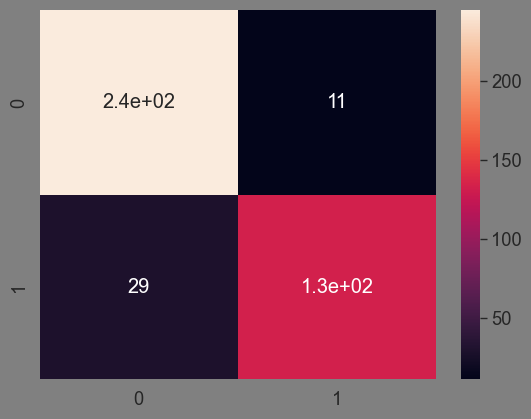

In [88]:
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True)
plt.show()

In [ ]:
%%time
# parameters for RF search

rf_params={ 'max_depth':[None, 3, 5, 8, 10],
           'max_features': ['sqrt', 'log2', None, 3, 10],
           'n_estimators': [5,10,20,100],
           'min_samples_split': [2,5,10]
}

rf_cv_model = GridSearchCV(RandomForestClassifier(random_state=24), 
                           rf_params,
                           cv=5,
                           n_jobs=-1, 
                           verbose=1)

rf_cv_model.fit(X_train, y_train)

In [90]:
rf_cv_model.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 100}

In [91]:
rf2 = RandomForestClassifier(
    n_estimators      =rf_cv_model.best_params_['n_estimators'],
    max_depth         =rf_cv_model.best_params_['max_depth'],
    max_features      =rf_cv_model.best_params_['max_features'],
    min_samples_split = rf_cv_model.best_params_['min_samples_split'],
    random_state=24
)

rf2.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', random_state=24)

In [92]:
rf_pred2=rf2.predict(X_test)
accuracy_score(y_test, rf_pred2)

0.8779904306220095

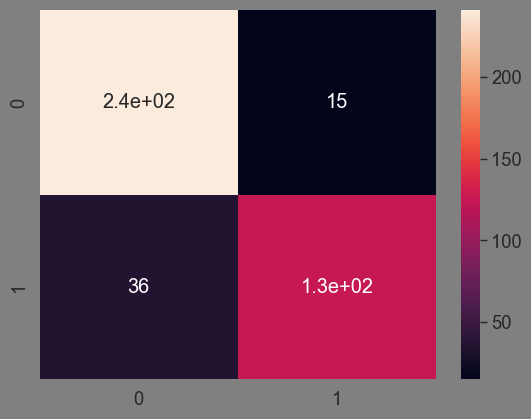

In [93]:
sns.heatmap(confusion_matrix(y_test, rf_pred2), annot=True)
plt.show()

In [94]:
# Get the best estimator
best_rf = rf_cv_model.best_estimator_

# Use the best estimator for predictions
y_pred = best_rf.predict(X_test)

# Print the best parameters
print("Best Parameters:", rf_cv_model.best_params_)

# Print the best score
print("Best Score:", rf_cv_model.best_score_)

# Print the best estimator
print("Best Estimator:", best_rf)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8369199517552213
Best Estimator: RandomForestClassifier(max_features='log2', random_state=24)


In [95]:
#### force the fit-predict process cycling through all test values for the defined hyperparameters

In [ ]:
# force the fit-predict process cycling through all test values for the defined hyperparameters
max_depth = [None, 3, 5, 8, 10]
max_features=  ['sqrt', 'log2', None, 3, 10]
n_estimators=  [5,10,20,100]
min_samples_split=  [2,5,10]
accs = []

for dp in max_depth:
    for mf in max_features:
        for ne in n_estimators:
            for mss in min_samples_split:
                rf = RandomForestClassifier(max_depth=dp, max_features=mf, n_estimators=ne, min_samples_split=mss, random_state=24)
                rf.fit(X_train, y_train)
                rf_pred = rf.predict(X_test)
                accs.append((accuracy_score(y_test, rf_pred),(dp,mf,ne,mss)))
                
                print(f'Random Forest Accuracy {dp} {mf} {ne} {mss}:', accuracy_score(y_test, rf_pred))

Random Forest Accuracy None sqrt 5 2: 0.8971291866028708
Random Forest Accuracy None sqrt 5 5: 0.9258373205741627
Random Forest Accuracy None sqrt 5 10: 0.8971291866028708
Random Forest Accuracy None sqrt 10 2: 0.8755980861244019
Random Forest Accuracy None sqrt 10 5: 0.9090909090909091
Random Forest Accuracy None sqrt 10 10: 0.8803827751196173
Random Forest Accuracy None sqrt 20 2: 0.8827751196172249
Random Forest Accuracy None sqrt 20 5: 0.9090909090909091
Random Forest Accuracy None sqrt 20 10: 0.9019138755980861
Random Forest Accuracy None sqrt 100 2: 0.9043062200956937
Random Forest Accuracy None sqrt 100 5: 0.9138755980861244
Random Forest Accuracy None sqrt 100 10: 0.9114832535885168
Random Forest Accuracy None log2 5 2: 0.8732057416267942
Random Forest Accuracy None log2 5 5: 0.8875598086124402
Random Forest Accuracy None log2 5 10: 0.8636363636363636
Random Forest Accuracy None log2 10 2: 0.8636363636363636
Random Forest Accuracy None log2 10 5: 0.8803827751196173
Random Fores

In [ ]:
max_tmp = 0
configs = ()
for item in accs:
    if item[0] >= max_tmp:
        max_tmp=item[0]
        configs = item[1]
max_tmp, configs

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import  cross_val_score 

In [ ]:
clf_svm = SVC()

In [ ]:
y_train=df_train['Survived']
X_train=df_train.drop(['Survived'],axis=1)
X_test=df_test.drop(['Survived'],axis=1)

In [ ]:
score = cross_val_score(clf_svm, X_train, y_train, scoring = 'accuracy', cv = 5, n_jobs = -1)#.mean()

In [ ]:
score,score.mean()

In [ ]:
modelo = clf_svm.fit(X_train, y_train)

In [ ]:
## TRAIN
modelo.score(X_train,y_train) #avaliar a performance em treino == predict e accuracy nos dados de treino 
                              #Naturalmente, melhor que CV

In [ ]:
y_pred = modelo.predict(X_test) # numa competiçao este y_pred e o que se submete

In [ ]:
# a competiçao ja e antiga e eles ja libertaram as labels
d_pred #.Survived.value_counts()

In [ ]:
y_test=d_pred.Survived
y_test

In [ ]:
## TEST
modelo.score(X_test,y_test)

In [ ]:
cm_svc = confusion_matrix(y_test,y_pred)
sns.heatmap(cm_svc, annot=True)
plt.show()

In [ ]:
cm_svc

#### OTIMIZAR os HIPERPARAMETROS - HPO

In [ ]:
parameters_svm = {'C':[0.9,0.01],'kernel':['rbf','linear'], 'gamma':[0.1,'auto']}#, 'probability':[True,False],
                  #'random_state':[0,7,16],'decision_function_shape':['ovo','ovr'],'degree':[3,4,10]}
    
    #C:
    #Kernel: 
    #gamma:

In [ ]:
def grid(model,parameters):
    grid = GridSearchCV(estimator = model, 
                        param_grid = parameters, 
                        cv =2, 
                        scoring = 'accuracy')
    grid.fit(X_train, y_train)
    return grid.best_score_, grid.best_estimator_.get_params()

In [ ]:
best_score_svm, best_params_svm = grid(clf_svm, parameters_svm)
print(best_score_svm)

In [ ]:
best_params_svm

In [ ]:
modelo.get_params()

In [ ]:
clf_svm2 = SVC(C=0.9,kernel='linear',gamma=0.1)
modelo2=clf_svm2.fit(X_train, y_train)
y_pred2=modelo2.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test,y_pred2)
sns.heatmap(cm, annot=True)
plt.show()

### Support functions

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

results_df=pd.DataFrame(columns=['Model','Accuracy','Precision','Recall','f1-score'])

def evaluate(reais, previstos):
    _accuracy = accuracy_score(reais, previstos)
    _precision = precision_score(reais, previstos)
    _recall = recall_score(reais, previstos)
    _f1 = f1_score(reais, previstos, average='weighted')
    return round(_accuracy,2), round(_precision,2), round(_recall,2), round(_f1,5)

def print_evaluate(model, reais, previstos):  
    accuracy, precision, recall, f1 = evaluate(reais, previstos)
    print('__________________________________')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('__________________________________')
    results=np.array([model,accuracy, precision, recall, f1])
    results_df.loc[len(results_df)+1]=results
    


In [ ]:
from time import time

def grid_search(model, params, _X, _y):
    GSCV = GridSearchCV(estimator=model
                    ,param_grid=params
                    ,cv=5
                    ,n_jobs = -1
                    ,verbose = 1)
    start = time()
    GSCV.fit(_X,_y)
    grid_time = time() - start
    print("Grid time:", grid_time)
    print(GSCV.best_params_) 
    return GSCV.best_params_

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
eval_sets = [
    (X_train, y_train),
#    (X_test, y_test)
]

In [ ]:
xgb_rf_c = xgb.XGBRFClassifier(random_state=24)

In [ ]:
####
xgb_rf_c = xgb.XGBRFClassifier(
                        # silent=False, 
#                          scale_pos_weight=1,
#                          learning_rate=0.01,  
#                          colsample_bytree = 0.99,
#                          subsample = 0.8,
#                          objective='binary:logistic', 
#                          n_estimators=100, 
#                          reg_alpha = 0.003,
#                          max_depth=10, 
#                          gamma=10,
#                          min_child_weight = 1,
#                          eval_metric = ["error", "logloss"],
                          random_state=24
                         )
xgb_rf_c.fit(X_train
              , y_train)

xgb_pred=xgb_rf_c.predict(X_test)

print_evaluate("XGB", y_test, xgb_pred)

In [ ]:
print("f1 score: ",f1_score(y_test, xgb_pred, average="weighted"))

print("\nClassification_report\n", classification_report (y_test, xgb_pred, digits=2, zero_division=True))

In [ ]:
xgb_rf_c.get_params()

In [ ]:
# Confusion Matrix with training data
train_predictions = xgb_rf_c.predict(X_train)#[:, 1]
cm = confusion_matrix(y_train, train_predictions)
plt.figure(figsize = (5,3))
sns.heatmap(cm, annot=True)
plt.show()

In [ ]:
# Confusion Matrix with test data
test_predictions = xgb_rf_c.predict(X_test)#[:, 1]
cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize = (5,3))
sns.heatmap(cm, annot=True)
plt.show()

#### Search for XGBoost's best hyperparameters 

In [ ]:
params_xgb = {
        'min_child_weight': [None,1, 5],
        'gamma': [None, 1, 10],
        'colsample_bytree': [None, 0.5, 1.0],
        'max_depth': [None, 5, 10],
        'n_estimators': [None, 100, 500]
        }

In [ ]:
%%time

folds = 2

grid = GridSearchCV(estimator=xgb_rf_c, param_grid=params_xgb, scoring='accuracy', n_jobs=-1, cv=folds, verbose=3 )
grid.fit(X_train, y_train)

#bestScore, bestParams = grid (xgb_rf_c, params)
#print(bestScore)
#print(bestParams)

In [ ]:
%%time

model=xgb.XGBRFClassifier(random_state=24)
best_params=grid_search(model, params_xgb, X_train, y_train)

# Create a new XGBoost Classifier
xgb_2=xgb.XGBRFClassifier(
    min_child_weight  = best_params['min_child_weight'],
    gamma             = best_params['gamma'],
    colsample_bytree  = best_params['colsample_bytree'],
    n_estimators      = best_params['n_estimators'],
    max_depth         = best_params['max_depth']
)


# Train it
xgb_2.fit(X_train, y_train)

# Make predictions on the test dataset
xgb_2_pred = xgb_2.predict(X_test)

print_evaluate("XGB optimized", y_test, xgb_2_pred)

In [ ]:
# Confusion Matrix with test data
cm = confusion_matrix(y_test, xgb_2_pred)
plt.figure(figsize = (5,3))
sns.heatmap(cm, annot=True)
plt.show()